# Neural Turing Machines: Tutorial

When Neural Networks started showing some marvellous results, two arguments came into picture to showcase their inefficieny.
1. Neural networks with fixed-size inputs are seemingly unable to solve problems with variable-size inputs.
2. Neural networks seem unable to store values to specific locations in data structures/memory.

First problem got resolved with the introduction of RNN(Recurrent Neural Networks), Whereas second problem's solution of using neural network with memory was proposed by a system called Neural Turing Machine 


As discussed above, A NTM is composed of two important things: a neural network, also known as controller, and a 2D matrix called memory. In this tutorial we will implement a simplistic version of both, and try to showcase copy task.

<img src="ntm_architecture.png" width="500"/>
NTM Architecture
<img src="NTM.png" width="800"/>
Controller and Memory connection

### COPY task for NMTs.

We will perform copy task for NMTs. NMTs are powerful at performing algrothmic tasks which need to store and access information in memory and Copy task is perfect example of it. In this exercise how well NTM perfoems on Copy task.

The task is as follows:
* The NTM model is shown a random k-dimenstional vector for T-time steps.
* The job of the network is output these T k-dimensional random vectors from zero-vectors at each time step.

#### Step 1: Import libraries 

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
from time import time
import torchvision.utils as vutils
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

#### Step 2: Implement Controller
As part of the controller, we will be implementing the following three components:

* A two-layer feedforward network. 
* Weight initialization using Xavier Approach.
* Sigmoid non-linearity

Note: We can have an LSTM controller as well, bue due to simplicity we build 2-layer fully connected controller. 

In [2]:
class Controller(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(Controller, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)
        self.intialize_parameters()

    def intialize_parameters(self):
        # Initialize the weights of linear layers
        nn.init.xavier_uniform_(self.layer1.weight, gain=1) # gain is set to 1 with sigmoid function
        nn.init.normal_(self.layer1.bias, std=0.01)
        nn.init.xavier_uniform_(self.layer2.weight, gain=1)
        nn.init.normal_(self.layer2.bias, std=0.01)

    def forward(self, x, last_read):
        # Forward pass operation, depending on last_read operation
        x = torch.cat((x, last_read), dim=1)
        x = torch.sigmoid(self.layer1(x))
        x = torch.sigmoid(self.layer2(x))
        return x

#### Step 3: Implement Memory

* Memory M is a 2-D matrix, with M rows, and N columns
* the function address() does the the memory addressing which is composed of four functions
    * similarity
    * interpolation
    * shifting
    * sharpening
    
<img src="ntm_equation.png" width="500"/>
Equations

In [3]:
class Memory(nn.Module):
    def __init__(self, M, N, controller_out):
        super(Memory, self).__init__()
        self.N = N
        self.M = M
        self.read_lengths = self.N + 1 + 1 + 3 + 1
        self.write_lengths = self.N + 1 + 1 + 3 + 1 + self.N + self.N
        self.w_last = [] # define to keep track of weight_vector at each time step.
        self.reset_memory()

    def get_weights(self):
        return self.w_last

    def reset_memory(self):
        # resets the memory for both read and write operations at start of new sequence (new input)
        self.w_last = []
        self.w_last.append(torch.zeros([1, self.M], dtype=torch.float32))

    def address(self, k, beta, g, s, gamma, memory, w_last):
        # Content focus
        wc = self._similarity(k, beta, memory) # CB1 to CB3 equations
        # Location focus
        wg = self._interpolate(wc, g, w_last) # CS1 equation
        w_hat = self._shift(wg, s) # CS2 and CS3 equation
        w = self._sharpen(w_hat, gamma) # S1 equation
        return w

    
    # Implementing Similarity on basis of CB1 followed by CB2 and CB3 Equation
    def _similarity(self, k, beta, memory):
        w = F.cosine_similarity(memory, k, -1, 1e-16) # CB1 Equation
        w = F.softmax(beta * w, dim=-1) # CB2 and CB3 Equation
        return w # return CB3 equation obtained weights
    
    # Implementing CS1 Equation. It decides whether to use the weights we obtained
    # at the previous time step w_last or use the weight obtained through similarity(content focus)
    def _interpolate(self, wc, g, w_last):
        return g * wc + (1 - g) * w_last
    
    # We will use Convolve shift for moving the head position.Each head gives shift weight s, 
    # to give us a distribution over which allowable integer shifts are performed.
    def _shift(self, wg, s):
        result = torch.zeros(wg.size())
        result = self._convolve(wg, s)
        return result
    
    #  because of the shift, weights focused at a single location will be dispersed into other locations, 
    # to mitigate this effect, sharpening was performed
    def _sharpen(self, w_hat, gamma):
        w = w_hat ** gamma
        w = torch.div(w, torch.sum(w, dim=-1) + 1e-16)
        return w
    
    # convolution shift
    def _convolve(self, w, s):
        b, d = s.shape
        assert b == 1, 'does _convolve work for b != 1?'
        assert d == 3
        w = torch.squeeze(w)
        t = torch.cat([w[-1:], w, w[:1]])
        c = F.conv1d(t.view(1, 1, -1), s.view(1, 1, -1)).view(b, -1)
        return c

#### Step 4: Implementing Read Operation
Here, We will define read heads which access memory and updates memory according to read operations we discuss in chapter above.

<img src="read_write_NTM.png" width="500"/>
Read and Write Equations

In [4]:
class ReadHead(Memory):

    def __init__(self, M, N, controller_out):
        super(ReadHead, self).__init__(M, N, controller_out)
        self.fc_read = nn.Linear(controller_out, self.read_lengths)
        self.intialize_parameters();
    
    # Initialize the linear layers
    def intialize_parameters(self):
        nn.init.xavier_uniform_(self.fc_read.weight, gain=1.4)
        nn.init.normal_(self.fc_read.bias, std=0.01)
    
    # Reading based on R2 equation
    def read(self, memory, w):
        return torch.matmul(w, memory)
    
    # Use Memory class we formed above to create a ReadHead operation
    def forward(self, x, memory):
        param = self.fc_read(x) # gather parameters
        # initialize necessary parameters k, beta, g, shift, and gamma
        k, beta, g, s, gamma = torch.split(param, [self.N, 1, 1, 3, 1], dim=1)
        k = torch.tanh(k)
        beta = F.softplus(beta)
        g = torch.sigmoid(g)
        s = F.softmax(s, dim=1)
        gamma = 1 + F.softplus(gamma) 
        # obtain current weight address vectors from Memory
        w = self.address(k, beta, g, s, gamma, memory, self.w_last[-1])
        # append in w_last function to keep track, while weighing content based
        # or location based weights
        self.w_last.append(w)
        # obtain current mem location based on R2 equation
        mem = self.read(memory, w)
        return mem, w


##### Step 5: Implement Write Operation
Similar to Read Operation, here we will implement write operation.

Note: Both read and write heads use fully connected layer to produce paremeters (k, beta, g, s, gamma) for content addressing. 

In [5]:
class WriteHead(Memory):

    def __init__(self, M, N, controller_out):
        super(WriteHead, self).__init__(M, N, controller_out)
        self.fc_write = nn.Linear(controller_out, self.write_lengths)
        self.intialize_parameters()

    def intialize_parameters(self):
        # Initialize the linear layers
        nn.init.xavier_uniform_(self.fc_write.weight, gain=1.4)
        nn.init.normal_(self.fc_write.bias, std=0.01)

    def write(self, memory, w, e, a):
        # Implement write function based on E1 and A1 Equation
        w, e, a = torch.squeeze(w), torch.squeeze(e), torch.squeeze(a)
        
        erase = torch.ger(w, e)
        m_tilde = memory * (1 - erase) # E1 equation
        
        add = torch.ger(w, a)
        memory_update = m_tilde + add # A1 equation

        return memory_update

    def forward(self, x, memory):
        param = self.fc_write(x) # gather parameters
        # initialize necessary parameters k, beta, g, shift, and gamma
        k, beta, g, s, gamma, a, e = torch.split(param, [self.N, 1, 1, 3, 1, self.N, self.N], dim=1)
        k = torch.tanh(k)
        beta = F.softplus(beta)
        g = torch.sigmoid(g)
        s = F.softmax(s, dim=-1)
        gamma = 1 + F.softplus(gamma)
        a = torch.tanh(a)
        e = torch.sigmoid(e)
        # obtain current weight address vectors from Memory
        w = self.address(k, beta, g, s, gamma, memory, self.w_last[-1])
        # append in w_last function to keep track, while weighing content based
        # or location based weights
        self.w_last.append(w)
        # obtain current mem location based on R2 equation
        mem = self.write(memory, w, e, a)
        return mem, w


#### Step 6: Implement Neural Turing Machine Structure, which includes:
1. fully connected controller
2. read and write heads
3. memory paramters
4. utility functions to operate on memory which is not trainable

Note: In the forward function, X can be none. This is because in Copy task, training happens in two steps for one particular sequence
* In the first step, the network is shown k-dimensional input for t time steps. 
* In the second step (prediction step), the network takes in k-dimensional zeros vector to produce predictions which performs copy of the input for each time step.

In [6]:
class NTM(nn.Module):
    def __init__(self, M, N, num_inputs, num_outputs, controller_out_dim, controller_hid_dim):
        super(NTM, self).__init__()
        # initialize number of input and outputs for the controller
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        # Define size of matrix
        self.M = M
        self.N = N
        # Initialize Memory
        self.memory = torch.zeros(self.M, self.N)
        self.last_read = torch.zeros(1, self.N) # Initialize size of last_read
        # Intialize Other components, Controller, read_head, and write_head
        self.controller = Controller(self.num_inputs + self.N, controller_out_dim, controller_hid_dim)
        self.read_head = ReadHead(self.M, self.N, controller_out_dim)
        self.write_head = WriteHead(self.M, self.N, controller_out_dim)
        
        self.fc_out = nn.Linear(self.num_inputs + N, self.num_outputs)
        self.intialize_parameters()
    
    def intialize_parameters(self):
        # Initialize the linear layers
        nn.init.xavier_uniform_(self.fc_out.weight, gain=1.4)
        nn.init.normal_(self.fc_out.bias, std=0.5)

    def forward(self, X=None):
        if X is None:
            X = torch.zeros(1, self.num_inputs)
        # initialize controller
        controller_out = self.controller(X, self.last_read)
        # operate the read and write operation
        self._read_write(controller_out)
        # use updated last_read to get sequence
        out = torch.cat((X, self.last_read), -1)
        out = torch.sigmoid(self.fc_out(out))

        return out

    def _read_write(self, controller_out):
        # Read Operation
        read, w = self.read_head(controller_out, self.memory)
        self.last_read = read
        # Write Operation
        mem, w = self.write_head(controller_out, self.memory)
        self.memory = mem

    def initalize_state(self):
        # reset memory of all the components
        stdev = 1 / (np.sqrt(self.N + self.M))
        self.memory = nn.init.uniform_((torch.Tensor(self.M, self.N)), -stdev, stdev)
        self.last_read = torch.tanh(torch.randn(1, self.N))
        self.read_head.reset_memory()
        self.write_head.reset_memory()

    def get_memory_info(self):
        # get all weights
        return self.memory, self.read_head.get_weights(), self.write_head.get_weights()

    def calculate_num_params(self):
        # Returns the total number of parameters.
        num_params = 0
        for p in self.parameters():
            num_params += p.data.view(-1).size(0)
        return num_params


##### Step 7: Generate a random sequence data to test COPY task
Here, we are generating a random sequence of vectors for COPY task. It is to be copied by NTM Model. 

In [7]:
class BinaySeqDataset(Dataset):

    def __init__(self, sequence_length, token_size, training_samples):
        self.seq_len = sequence_length
        self.seq_width = token_size
        self.dataset_dim = training_samples

    def _generate_seq(self):
        # A special token is appened at beginning and end of each
        # sequence which marks sequence boundaries.
        seq = np.random.binomial(1, 0.5, (self.seq_len, self.seq_width))
        seq = torch.from_numpy(seq)
        # Add start and end token
        inp = torch.zeros(self.seq_len + 2, self.seq_width)
        inp[1:self.seq_len + 1, :self.seq_width] = seq.clone()
        inp[0, 0] = 1.0
        inp[self.seq_len + 1, self.seq_width - 1] = 1.0
        outp = seq.data.clone()

        return inp.float(), outp.float()

    def __len__(self):
        return self.dataset_dim

    def __getitem__(self, idx):
        inp, out = self._generate_seq()
        return inp, out

We will also implement Gradient clipping as its generally a good idea to clip gradients so that the network is numerically stable.

In [8]:
def clip_grads(net, min_grad=-10,max_grad=10):
    parameters = list(filter(lambda p: p.grad is not None, net.parameters()))
    for p in parameters:
        p.grad.data.clamp_(min_grad,max_grad)

Initialize Parameters for Training

In [9]:
memory_capacity=64
memory_vector_size=128
controller_output_dim=256
controller_hidden_dim=512
learning_rate=1e-2

sequence_length, token_size, training_samples = 300, 10, 99
min_grad, max_grad = -10, 10

### Start training

In [10]:
# Initialize the dataset
dataset = BinaySeqDataset(sequence_length, token_size, training_samples)
# Initialize the dataloader with batchsize
dataloader = DataLoader(dataset, batch_size=1,shuffle=True, num_workers=4)
# Initialize the Model
model = NTM(M=memory_capacity,
            N=memory_vector_size,
            num_inputs=token_size,
            num_outputs=token_size,
            controller_out_dim=controller_output_dim,
            controller_hid_dim=controller_hidden_dim
            )

criterion = torch.nn.BCELoss()
# We can use Adam too.
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
losses = []

# Train the Model
for e, (X, Y) in enumerate(dataloader):
    tmp = time()
    model.initalize_state()
    optimizer.zero_grad()

    inp_seq_len = sequence_length + 2
    out_seq_len = sequence_length

    X.requires_grad = True

    # Forward Pass
    for t in range(0, inp_seq_len):
        model(X[:, t])

    # Predictions
    y_pred = torch.zeros(Y.size())
    for i in range(0, out_seq_len):
        y_pred[:, i] = model()
    
    # Optimize
    loss = criterion(y_pred, Y)
    loss.backward()
    clip_grads(model)
    optimizer.step()
    losses += [loss.item()]
    if (e%10==0):
        print("iteration: {}, Loss:{} ".format(e, loss.item()))
    # Train it for 5000 iterations. 
    if e == 5000:
        break

iteration: 0, Loss:1.202673316001892 
iteration: 50, Loss:0.6942700147628784 


### Define a plot signal function and Plot Training Loss

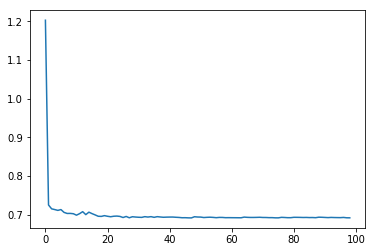

In [11]:
def plot_signal(grid_image, fig_size=(500,100)):
    plt.figure(figsize=fig_size)
    plt.imshow(grid_image.data.permute(2, 1, 0))

plt.plot(losses)
plt.show()

### Test the NTM Model's COPY Task
Here, we create a random signal of 300 time steps and see how well the model copies this signal.

In [12]:
X, Y = dataset._generate_seq()
X, Y = X.unsqueeze(0), Y.unsqueeze(0)# Add the batch dimension


model.initalize_state()

for t in range(0, inp_seq_len):
    model(X[:, t])

y_pred = torch.zeros(Y.size())
for i in range(0, out_seq_len):
    y_pred[:, i] = model()

In this step, you will observe the copy task output. These two signals should be very close, if they aren't we suggest you to train more.

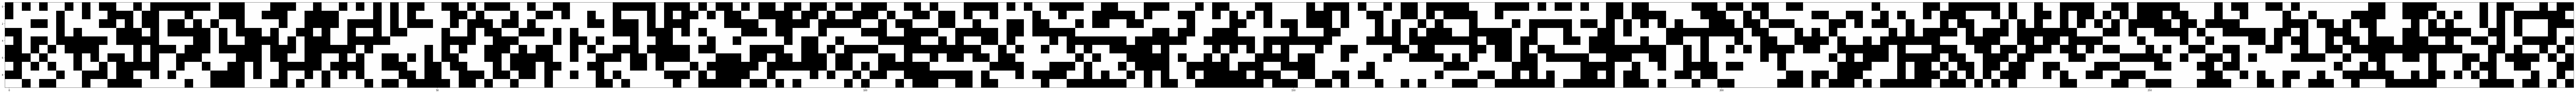

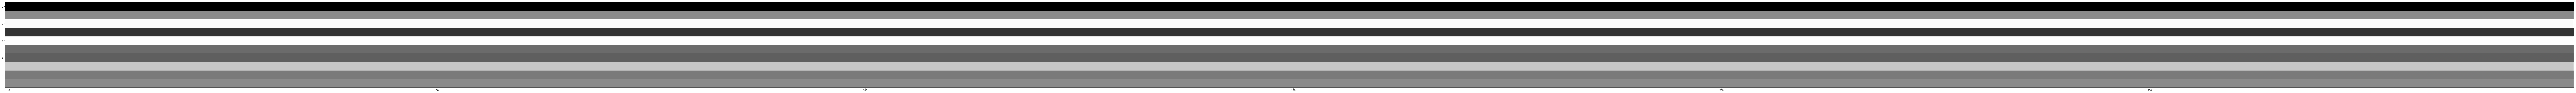

In [13]:
# Plot ground truth signal Y and signal y_pred predicted by model.
# In Copy task these two signals should be very close. 

grid_img_truth = vutils.make_grid(Y, normalize=True, scale_each=True)
grid_img_pred = vutils.make_grid(y_pred, normalize=True, scale_each=True)

plt.figure(figsize=(200,200))
plt.imshow(grid_img_truth.data.permute(2, 1, 0))

plt.figure(figsize=(200,200))
plt.imshow(grid_img_pred.data.permute(2, 1, 0))